# Tutorial 2: Feedforward Neural Networks

**The purpose of this tutorial is to demonstrate how to work with an open source software library for developing deep neural networks apllications, called TensorFlow. In this tutorial, we will focus on**:  
- ***Inspect the common pipeline of deep learning*.**
- ***How to implement a feedforward neural net for a multi-class classfication problem using PyTorch*.**

### <span style="color:#0b486b"> II.0 Running on Google Colab</span> <span style="color:red"></span>
You will need to download relevant files to run this notebook on Google Colab.

In [ ]:
!gdown https://drive.google.com/uc?id=1oNteaVQ4J6sPEPwTUoFMwjN4C5wEt2-r

Downloading...
From: https://drive.google.com/uc?id=1oNteaVQ4J6sPEPwTUoFMwjN4C5wEt2-r
To: /content/Tut02_data.zip
100% 1.81M/1.81M [00:00<00:00, 18.3MB/s]


In [ ]:
!unzip -q Tut02_data.zip

### <span style="color:#0b486b"> II.1 Feedforward Neural Network </span> <span style="color:red">***** (highly important)</span>
#### <span style="color:#0b486b"> Tutorial objective </span>

In this tutorial we consider a fairly realistic deep NNs with *three* layers plus the *output* layer. Its architecture is specified as: $16 \rightarrow 10 (ReLU) \rightarrow 20 (ReLU) \rightarrow 15 (ReLU) \rightarrow 26$, meaning that:
- Input size is 16
- First layer has 10 hidden units with ReLU activation function
- Second layer has 20 hidden units with 20 ReLU activiation function
- Third layer has 15 hidden units with 15 ReLU activiation function
- And output layer is logit layer with 26 hidden units

This network, for example, can take the `letter` dataset input with $16$ features and with $26$ classes (A-Z). **Our objective in this tutorial is to implement this specific network in `PyTorch`.**

#### <span style="color:#0b486b">Specifying the Neural Network Architecture </span>

We can visualize this network as in the figure below. Note that for readability, the number of hidden units in the figure might not equal exactly to the actual size of the hidden units used.

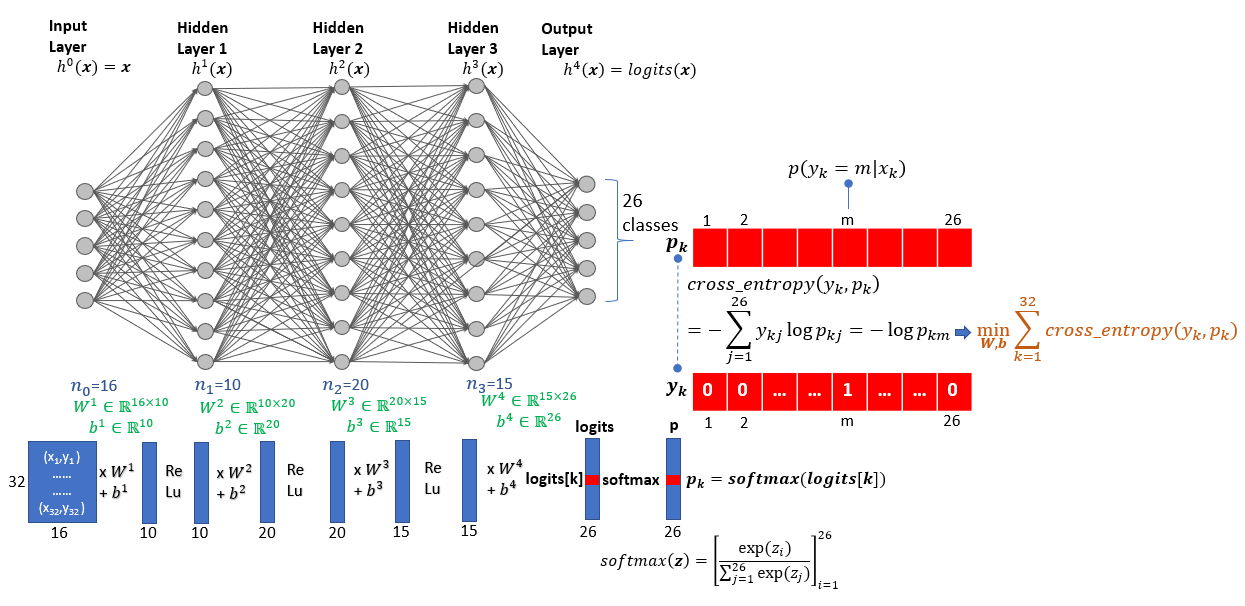

Furthermore, the above figure shows the pipeline of the entire process for feeding a mini-batch of batch size $32$ into the network. Using ***mini-batch*** is a common way to train deep NNs in practice.

Let us denote the mini-batch by $X_b= \{(x_1, y_1),\dots, (x_{32}, y_{32})\}$. The mini-batch can be stored using a $2D$ tensor with the shape $(32, 16)$. Assume that in this network, we use the activation function $ReLu$ where $ReLu(t)= \max\{0, t\}$. The computation in the forward propagation step is as follows:
- Input $X_b$ with mini-batch size of 32
- $h_1= ReLu(X_b \times W^1 + b^1)\in \mathbb{R}^{32 \times 10}$.
- $h_2= ReLu(h_1 \times W^2 + b^2)\in \mathbb{R}^{32 \times 20}$.
- $h_3= ReLu(h_2 \times W^3 + b^3)\in \mathbb{R}^{32 \times 15}$.
- $logits= h_3 \times W^4 + b^4 \in \mathbb{R}^{32 \times 26}$
- $p = softmax(logits) \in \mathbb{R}^{32 \times 26}$ <br>

where we note that the activation function is perfomed element-wise and the softmax function is used to transform a vector of scalars to a discrete distribution as:

$$softmax(z)=\big[\frac{\exp(z_i)}{\sum_{j=1}^{26}{\exp(z_j)}}\big]_{i=1}^{26}$$

The $k$-th row $p_k$ of the matrix $p$ can represent the probability distribution to classify the data point $x_k$ to the classes $1,2,\dots,26$. In particular, we have:

$$p_{km}= p(y_k=m \mid x_k)  \text{ for }  m=1,2,\dots,26$$

**<span style="color:red"> Exercise 1</span>** : Explain why the dimension for $h_1$ is $32\times 10$? Similarly, please work out the dimension for $h2, h3, logits$ and $p$.

- $X_b$ has shape $(32 , 16)$ and $W^1$ has shape $(16, 10)$. Hence $X_b \times W^1 + b^1$ has shape $(32,10)$. Note that $b^1$ has shape $(1,10)$ and broadcasting is used to add $b^1$ to the tensor $(32,10)$.  

#### <span style="color:#0b486b">Specifying the Loss Function </span>
Essiential to training a deep NN is the concept of the **loss function**. This function tells us how good the network is predicting, and hence we can use this loss to find the network weights in such a way that the loss can be minimized.

For classification task, a common approach is to use the **cross-entropy** loss function. Given a data-label instance $(x_k,y_k)$ where feature $x_k\in \mathbb{R}^{16}$ and the label $y_k \in \{1,2,...,26\}$ is a numeric label (for example if $x_k$ is in the class 2, then $y_k =2 $ and its one-hot vector $1_{y_k}=[0,1,0,...,0]$). The cross-entroty between the classification distribution $p_k$ returned from the NN and true label distribution $y_k$ is defined as:
$$cross\_entropy(1_{y_k}, p_k)=-\sum_{j=1}^{26}y_{kj}\log{p_{kj}}=-\log p_{k,y_k}$$. This loss basically enforces the model to predict the label as close as the true label by minimizing $cross\_entropy(1_{y_k}, p_k)$

The above loss function was applied for each instance. For the entire current mini-batch, our loss function becomes:
$$\min \sum_{k=1}^{32}cross\_entropy(1_{y_k}, p_k)$$

**<span style="color:red"> Exercise 2: </span>** : **<span style="color:#0b486b">In the cross-entropy equation above, $y_k$ is the class for $x_k$, explain why the end result is $-\log p_{k,y_k}$.</span>**

- This is based on $CE(1_y,p) = CE([0,0,...,1_y,0,...,y], [p_1, ...,p_y,...,p_M])= - log p_y$.

### <span style="color:#0b486b"> II.2 Implementation with PyTorch</span> <span style="color:red">***** (highly important)</span>
We now shall implement the aforementioned network with the architecture of $16 \rightarrow 10 (ReLU) \rightarrow 20 (ReLU) \rightarrow 15 (ReLu) \rightarrow 26$ in PyTorch using the dataset `letter`.

This letter dataset can be found at [the LIBSVM website](https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/multiclass.html#letter). Here is the dataset information:
-  *The objective is to identify each of a large number of black-and-white rectangular pixel displays as one of the 26 capital letters in the English alphabet. The character images were based on 20 different fonts and each letter within these 20 fonts was randomly distorted to produce a file of 20,000 unique stimuli. Each stimulus was converted into 16 primitive numerical attributes (statistical moments and edge counts) which were then scaled to fit into a range of integer values from 0 through 15*

A typical pipeline process of implementing a deep learning model is as follows:

1. **Data processing**:
    - Load the dataset and split into train, valid, and test sets.  
     
2. **Building the model**:
    - Build the model using PyTorch layers.
     
3. **Declaring the loss and optimizer**:
    - Specify the optimizer, the loss (e.g., cross-entropy loss) you want to optimize.
    
4. **Training and evalutating**:
    - Train the model with specific training set and validation set in a number of epochs.
    - Predict on the test set and assess its performance.

#### <span style="color:#0b486b">1. Data Processing </span>

We use `sklearn` to load the dataset.

In [ ]:
import os
import numpy as np
from sklearn.datasets import load_svmlight_file

In [ ]:
data_file_name= "letter_scale.libsvm"
data_file = os.path.abspath("./Data/" + data_file_name)
X_data, y_data = load_svmlight_file(data_file)
X_data= X_data.toarray()
y_data= y_data.reshape(y_data.shape[0],-1)
print("X data shape: {}".format(X_data.shape))
print("y data shape: {}".format(y_data.shape))
print("# classes: {}".format(len(np.unique(y_data))))
print(np.unique(y_data))

X data shape: (15000, 16)
y data shape: (15000, 1)
# classes: 26
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26.]


We use `sklearn` to split the dataset into the train, validation, and test sets.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

def train_valid_test_split(data, target, train_size, test_size):
    valid_size = 1 - (train_size + test_size)
    X1, X_test, y1, y_test = train_test_split(data, target, test_size = test_size, random_state= 33)
    X_train, X_valid, y_train, y_valid = train_test_split(X1, y1, test_size = float(valid_size)/(valid_size+ train_size))
    return X_train, X_valid, X_test, y_train, y_valid, y_test

Next, we would like to encode the label in the form of numeric vector. For example, we want to turn $y\_data=["cat", "dog", "cat", "lion", "dog"]$ to $y\_data=[0,1,0,2,1]$.

To do this, in the following segment of code, we use the object `le` as an instance of the class `preprocessing.LabelEncoder()` which supports us to transform catefgorial labels in `y_data` to numerical vector.

In [ ]:
le = preprocessing.LabelEncoder()
le.fit(y_data.ravel())
y_data= le.transform(y_data.ravel())
y_data = y_data.ravel()
print(y_data[:])

[25 15 18 ...  0 11 21]


In [ ]:
X_train, X_valid, X_test, y_train, y_valid, y_test = train_valid_test_split(X_data, y_data,
                                                                            train_size=0.8,
                                                                            test_size=0.1)
y_train= y_train.reshape(-1)
y_test= y_test.reshape(-1)
y_valid= y_valid.reshape(-1)
print(X_train.shape, X_valid.shape, X_test.shape)
print(y_train.shape, y_valid.shape, y_test.shape)
print("lables: {}".format(np.unique(y_train)))

(12000, 16) (1500, 16) (1500, 16)
(12000,) (1500,) (1500,)
lables: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]


#### Batching Data

In [ ]:
from torch.utils.data import Dataset, DataLoader
import torch

In [ ]:
class MyDataset(Dataset):
    def __init__(self, data, labels):
        super(MyDataset, self).__init__()
        assert data.shape[0] == labels.shape[0]  #assuming shape[0] = dataset size
        self.data = torch.tensor(data, dtype = torch.float32)
        self.labels = torch.tensor(labels, dtype = torch.float32)

    def __len__(self):
        return self.labels.shape[0]

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [ ]:
train_data = MyDataset(X_train, y_train)
valid_data = MyDataset(X_valid, y_valid)
test_data = MyDataset(X_test, y_test)
train_data[0:5]

(tensor([[-0.6000, -0.2000, -0.4667, -0.4667, -0.4667, -0.0667,  0.0667, -0.4667,
          -0.2000,  0.0667,  0.0667, -0.2000, -0.3333,  0.2000, -0.6000, -0.0667],
         [-0.6000, -0.4667, -0.4667, -0.6000, -0.8667, -0.4667,  0.6000, -0.6000,
          -0.6000,  0.3333,  0.4667, -0.0667, -0.7333,  0.4667, -0.8667,  0.0667],
         [-0.6000, -0.8667, -0.4667, -0.6000, -0.7333, -0.0667,  0.6000, -0.4667,
          -0.2000, -0.0667,  0.4667,  0.0667, -0.7333,  0.4667, -0.8667,  0.0667],
         [-0.4667, -0.0667, -0.2000, -0.3333, -0.4667,  0.3333, -0.0667, -0.6000,
          -0.0667,  0.4667, -0.7333, -0.2000, -0.4667, -0.3333, -0.6000,  0.2000],
         [-0.4667, -0.2000, -0.2000, -0.4667, -0.2000, -0.0667,  0.0667, -0.6000,
          -0.3333, -0.2000, -0.0667,  0.4667, -0.6000,  0.3333, -0.0667,  0.0667]]),
 tensor([ 5., 21., 19., 17.,  4.]))

In [ ]:
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=True)

In [ ]:
# Print out the first two batches
for i, (vectors, labels) in enumerate(train_loader):
    if i >= 2:
        break
    print(f"Batch {i+1}:")
    print(f"Batch shape: {vectors.shape}")
    print(f"Labels: {labels}")
    print()

Batch 1:
Batch shape: torch.Size([64, 16])
Labels: tensor([ 7., 16., 12.,  5.,  9., 24.,  7., 17.,  7.,  5., 25.,  6.,  2.,  3.,
        21.,  9.,  3., 11., 20., 20., 13., 22., 25., 16., 17., 22., 12., 21.,
         9., 19.,  8.,  3.,  8., 18., 11.,  5., 13., 19., 14.,  8.,  7.,  0.,
        17., 23., 21., 14., 22., 17., 18., 17., 22., 11., 13.,  8.,  0., 22.,
        19., 19.,  2., 12.,  0., 10.,  4., 23.])

Batch 2:
Batch shape: torch.Size([64, 16])
Labels: tensor([19.,  2.,  0., 13., 22., 19.,  3., 19.,  7., 23.,  6., 19.,  9., 25.,
         3., 23., 17., 25., 20.,  5.,  6.,  3., 13., 22., 23., 19., 20., 14.,
        10., 13., 19., 20., 24., 22., 23.,  7., 17., 24., 16.,  2., 19.,  5.,
        21., 25., 22.,  5., 19.,  5., 25., 24.,  5., 23., 25., 24.,  3., 23.,
        13.,  5., 15., 19.,  7., 11., 12., 16.])



In [ ]:
train_size= int(X_train.shape[0])
n_features= int(X_train.shape[1])
n_classes= len(np.unique(y_train))
print(f"Train size: {train_size}, # features: {n_features}, and number of classes: {n_classes}")

Train size: 12000, # features: 16, and number of classes: 26


In [ ]:
import torch
import torch.nn as nn
from torch.nn import Linear, Sequential

#### <span style="color:#0b486b">2. Build up the model </span>

We build up a feedforward neural network with the architecture: $16 \rightarrow 10 (ReLU) \rightarrow 20 (ReLU) \rightarrow 15 (ReLu) \rightarrow 26$ in PyTorch.

Note that we only return the logits because the cross-entropy loss we use later includes the softmax.

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dnn_model = Sequential(Linear(n_features,10), nn.ReLU(),
                       Linear(10,20), nn.ReLU(),
                       Linear(20,15), nn.ReLU(),
                       Linear(15, n_classes)).to(device) #load the model to device


We print out the model summary.

In [ ]:
from torchsummary import summary

summary(dnn_model, (1,16))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 10]             170
              ReLU-2                [-1, 1, 10]               0
            Linear-3                [-1, 1, 20]             220
              ReLU-4                [-1, 1, 20]               0
            Linear-5                [-1, 1, 15]             315
              ReLU-6                [-1, 1, 15]               0
            Linear-7                [-1, 1, 26]             416
Total params: 1,121
Trainable params: 1,121
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


We declare the function `compute_loss` to compute the loss. This function has three parameters: the DL model, the loss function, and the data loader. Specifically, we gradually feed the mini-batches of the loader to the model and compute the sum/average of the losses of the mini-batches.

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def compute_loss(model, loss_fn, loader):
  model.eval()
  loss = 0
  for (batchX, batchY) in loader:
    batchX, batchY = batchX.to(device), batchY.to(device)
    loss += loss_fn(model(batchX.type(torch.float32)), batchY.type(torch.long))
  return float(loss)/len(loader)

We declare the function `compute_acc` to compute the accuracy. This function has two parameters: the DL model and the data loader. Specifically, we gradually feed the mini-batches of the loader to the model and compute the total number of correct predictions.

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def compute_acc(model, loader):
  # Change the model to the evaluation mode (important for the model with batch-norm and drop-out layers)
  model.eval()
  # In test phase, we don't need to compute gradients (for memory efficiency)
  with torch.no_grad():
    corrects = 0
    totals =0
    for (batchX, batchY) in loader:
      batchX, batchY = batchX.to(device), batchY.to(device)
      outputs = model(batchX.type(torch.float32)) #feed batch to the model
      totals += batchY.size(0) #accumulate totals with the current batch size
      predicted = torch.argmax(outputs.data, 1) #get the predicted class
      corrects += (predicted == batchY.type(torch.long)).sum().item() #accumulate correct predictions
  acc = float(corrects)/totals #compute the accuracy
  return acc

#### <span style="color:#0b486b">3. Declaring the Loss and Optimizer </span>


In [ ]:
# Loss and optimizer
learning_rate = 0.005
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(dnn_model.parameters(), lr=learning_rate)

#### <span style="color:#0b486b">4. Training the Model </span>


We train our model in $100$ epochs. We record the `train_acc`, `train_loss`, `valid_acc`, and `valid_loss` across the training epochs for visualizing the learning curve later.

In [ ]:
# Train the model
num_epochs = 100
history = dict() #declare the dictionary history with the keys:val_loss, val_acc, train_loss, train_acc
history['val_loss'] = list()
history['val_acc'] = list()
history['train_loss'] = list()
history['train_acc'] = list()
for epoch in range(num_epochs):
    #Set our model in training mode
    dnn_model.train()
    for i, (X, y) in enumerate(train_loader):
        X, y = X.to(device), y.to(device)
        # Forward pass
        outputs = dnn_model(X.type(torch.float32))
        loss = loss_fn(outputs, y.type(torch.long))
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    #losses and accuracies for epoch
    val_loss = compute_loss(dnn_model, loss_fn, valid_loader)
    val_acc = compute_acc(dnn_model, valid_loader)
    train_loss = compute_loss(dnn_model, loss_fn, train_loader)
    train_acc = compute_acc(dnn_model, train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"train loss= {train_loss:.4f} - train acc= {train_acc*100:.2f}% - valid loss= {val_loss:.4f} - valid acc= {val_acc*100:.2f}%")
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)

/tmp/ipython-input-2790395491.py:9: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:835.)
  return float(loss)/len(loader)


Epoch 1/100
train loss= 1.8392 - train acc= 40.92% - valid loss= 1.8731 - valid acc= 40.20%
Epoch 2/100
train loss= 1.3999 - train acc= 56.85% - valid loss= 1.4474 - valid acc= 56.00%
Epoch 3/100
train loss= 1.2069 - train acc= 63.68% - valid loss= 1.2346 - valid acc= 62.87%
Epoch 4/100
train loss= 1.0682 - train acc= 67.37% - valid loss= 1.0704 - valid acc= 67.07%
Epoch 5/100
train loss= 0.9768 - train acc= 70.17% - valid loss= 1.0037 - valid acc= 68.93%
Epoch 6/100
train loss= 0.9266 - train acc= 71.86% - valid loss= 0.9371 - valid acc= 72.13%
Epoch 7/100
train loss= 0.8814 - train acc= 72.82% - valid loss= 0.9026 - valid acc= 72.40%
Epoch 8/100
train loss= 0.8687 - train acc= 73.04% - valid loss= 0.8937 - valid acc= 71.40%
Epoch 9/100
train loss= 0.8196 - train acc= 75.23% - valid loss= 0.8447 - valid acc= 73.53%
Epoch 10/100
train loss= 0.7935 - train acc= 75.22% - valid loss= 0.8290 - valid acc= 73.67%
Epoch 11/100
train loss= 0.7812 - train acc= 76.52% - valid loss= 0.8238 - vali

#### <span style="color:#0b486b">5. Visualizing the Performance and Loss Objective Function </span>

There are four keys in the history dictionary: `train_loss` and `val_loss` measure the loss on the training set and the validation set, respectively, while `train_acc` and `val_acc` measure the accuracy on the training set and the validation set.  
The following figure visualize all four metrics with two y-axes, losses (blue lines, in descending) and accuracies (red lines, in asending)


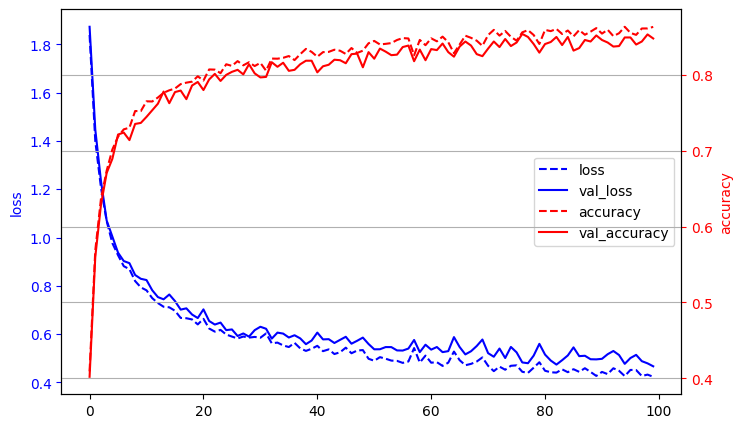

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

his = history
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
ln1 = ax.plot(his['train_loss'], 'b--',label='loss')
ln2 = ax.plot(his['val_loss'], 'b-',label='val_loss')
ax.set_ylabel('loss', color='blue')
ax.tick_params(axis='y', colors="blue")

ax2 = ax.twinx()
ln3 = ax2.plot(his['train_acc'], 'r--',label='accuracy')
ln4 = ax2.plot(his['val_acc'], 'r-',label='val_accuracy')
ax2.set_ylabel('accuracy', color='red')
ax2.tick_params(axis='y', colors="red")

lns = ln1 + ln2 + ln3 + ln4
labels = [l.get_label() for l in lns]
ax.legend(lns, labels, loc=7)
plt.grid(True)
plt.show()

#### <span style="color:#0b486b">6. Playing around with different optimizers</span>
In the following code, we try different optimizers to find the optimal one which has the best performance (evaluated on the validation set).
It can be done easily by passing an specific optimizer when compiling model.

To do so, we first need to modulize the training procedure.

In [ ]:
def create_model():
  dnn_model = Sequential(Linear(n_features,10), nn.ReLU(),
                       Linear(10,20), nn.ReLU(),
                       Linear(20,15), nn.ReLU(),
                       Linear(15, n_classes))
  return dnn_model

We write the function `fit` to train the model in many epochs. In this function, we declare all necessary components and specifications for training a model.

In [ ]:
def fit(model= None, train_loader = None, valid_loader= None, optimizer = torch.optim.Adam,
        learning_rate=0.001, num_epochs = 50, verbose = True, seed= 1234):
  torch.manual_seed(seed) #set the random seed for Torch
  optim = optimizer(model.parameters(), lr = learning_rate) #declare optimizer
  history = dict() #initialize the history for keep tracking of training information
  history['val_loss'] = list()
  history['val_acc'] = list()
  history['train_loss'] = list()
  history['train_acc'] = list()
  for epoch in range(num_epochs):
      model.train() #set the model in training mode
      for i, (X, y) in enumerate(train_loader):
          X, y = X.to(device), y.to(device)
          # Forward pass
          outputs = model(X.type(torch.float32))
          loss = loss_fn(outputs, y.type(torch.long))
          # Backward and optimize
          optim.zero_grad()
          loss.backward()
          optim.step()
      #losses and accuracies for epoch
      val_loss = compute_loss(model, loss_fn, valid_loader)
      val_acc = compute_acc(model, valid_loader)
      train_loss = compute_loss(model, loss_fn, train_loader)
      train_acc = compute_acc(model, train_loader)
      history['val_loss'].append(val_loss)
      history['val_acc'].append(val_acc)
      history['train_loss'].append(train_loss)
      history['train_acc'].append(train_acc)
      if not verbose: #verbose = True means we do not show the training information during training
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"train loss= {train_loss:.4f} - train acc= {train_acc*100:.2f}% - valid loss= {val_loss:.4f} - valid acc= {val_acc*100:.4f}%")
  return history

We iterate through various optimizers in `optim_dict`. For each optimizer, we create a fresh new FFN and train it from scratch.

In [ ]:
from torch import optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
optim_dict = {"Adam":optim.Adam, "Adadelta":optim.Adadelta, "Adagrad":optim.Adagrad,
                  "Adamax":optim.Adamax, "AdamW": optim.AdamW, "ASGD":optim.ASGD,
                  "NAdam":optim.NAdam, "RMSprop":optim.RMSprop, "RAdam":optim.RAdam,
                  "Rprop": optim.Rprop, "SGD":optim.SGD}
best_acc = 0
for optim_name, optim in optim_dict.items():
    print("*Evaluating with {}\n".format(optim_name))
    dnn_model = create_model().to(device)
    history = fit(dnn_model, train_loader = train_loader, valid_loader= valid_loader,
        optimizer = optim, learning_rate = 0.005, num_epochs =50, verbose= True)

    val_acc = history['val_acc'][-1]
    print(f"===>The valid accuracy is {val_acc*100:.2f}%\n")
    if val_acc > best_acc:
        best_acc = val_acc
        best_optim = optim_name
        best_model = dnn_model
print(f"The best valid accuracy is {best_acc*100:.2f}% with {best_optim}")


*Evaluating with Adam

===>The valid accuracy is 80.33%

*Evaluating with Adadelta

===>The valid accuracy is 7.07%

*Evaluating with Adagrad

===>The valid accuracy is 50.20%

*Evaluating with Adamax

===>The valid accuracy is 76.47%

*Evaluating with AdamW

===>The valid accuracy is 81.07%

*Evaluating with ASGD

===>The valid accuracy is 9.47%

*Evaluating with NAdam

===>The valid accuracy is 81.07%

*Evaluating with RMSprop

===>The valid accuracy is 79.60%

*Evaluating with RAdam

===>The valid accuracy is 82.27%

*Evaluating with Rprop

===>The valid accuracy is 32.93%

*Evaluating with SGD

===>The valid accuracy is 9.60%

The best valid accuracy is 82.27% with RAdam


#### <span style="color:#0b486b">7. Fine-tuning the learning rate</span>
Learning rate plays an important role when training a deep learning model. In the following code, we will try a simple greedy search to find a good learning rate.

In [ ]:
lr = [1e-2, 5e-3, 1e-3, 1e-4, 5e-4]

best_acc = 0
best_i = -1
for i in range(len(lr)):
    print(f"*Evaluating with learning rate = {lr[i]:.4f}\n")
    dnn_model = create_model().to(device)
    history = fit(dnn_model, train_loader = train_loader, valid_loader= valid_loader,
        optimizer = torch.optim.Adam, learning_rate = lr[i], num_epochs =30, verbose= True)
    valid_acc = history["val_acc"][-1]
    print(f"===>The valid accuracy is {valid_acc*100:.2f}%\n")
    if valid_acc > best_acc:
        best_acc = valid_acc
        best_i = i
        best_model = dnn_model
print(f"The best valid accuracy is {best_acc*100:.2f}% with learning rate {lr[best_i]:.4f}")

*Evaluating with learning rate = 0.0100

===>The valid accuracy is 80.53%

*Evaluating with learning rate = 0.0050

===>The valid accuracy is 81.00%

*Evaluating with learning rate = 0.0010

===>The valid accuracy is 71.87%

*Evaluating with learning rate = 0.0001

===>The valid accuracy is 41.27%

*Evaluating with learning rate = 0.0005

===>The valid accuracy is 64.47%

The best valid accuracy is 81.00% with learning rate 0.0050


#### <span style="color:#0b486b">8. Save and Load Models</span>

We save the best model to the file `best_model.pth`.

In [ ]:
# Save model
torch.save(best_model.state_dict(), "best_model.pth")

We load the best model from the file.

In [ ]:
# Load model
dnn_model = create_model()
dnn_model.load_state_dict(torch.load("best_model.pth"))
dnn_model = dnn_model.to(device)
dnn_model.eval()

Sequential(
  (0): Linear(in_features=16, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=20, bias=True)
  (3): ReLU()
  (4): Linear(in_features=20, out_features=15, bias=True)
  (5): ReLU()
  (6): Linear(in_features=15, out_features=26, bias=True)
)

We evaluate the model on the testing set.

In [ ]:
test_acc = compute_acc(dnn_model, test_loader)
print(f"Test accuracy: {test_acc*100:.2f}%")

Test accuracy: 80.07%


#### <span style="color:#0b486b">9. Another way to implement FFN</span>

We build up a deep net class that inherits from `torch.nn.Module`.

In [ ]:
from torch import nn
import torch.nn.functional as F

class OurFFN(torch.nn.Module):
  def __init__(self, n_features, n_classes):
    super(OurFFN, self).__init__()
    self.n_features = n_features
    self.n_classes = n_classes
    self.fc1 = nn.Linear(n_features, 10)
    self.fc2 = nn.Linear(10, 20)
    self.fc3 = nn.Linear(20, 15)
    self.fc4 = nn.Linear(15, n_classes)

  def forward(self, x): #x is the mini-batch
    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)
    x = F.relu(x)
    x = self.fc3(x)
    x = F.relu(x)
    x = self.fc4(x)
    return x

In [ ]:
from torchsummary import summary

ffn_model = OurFFN(n_features, n_classes).to(device)
summary(ffn_model, (1,n_features))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 10]             170
            Linear-2                [-1, 1, 20]             220
            Linear-3                [-1, 1, 15]             315
            Linear-4                [-1, 1, 26]             416
Total params: 1,121
Trainable params: 1,121
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [ ]:
# Loss and optimizer
learning_rate = 0.005
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(ffn_model.parameters(), lr=learning_rate)

In [ ]:
# Train the model
num_epochs = 100
history = dict() #declare the dictionary history with the keys:val_loss, val_acc, train_loss, train_acc
history['val_loss'] = list()
history['val_acc'] = list()
history['train_loss'] = list()
history['train_acc'] = list()
for epoch in range(num_epochs):
    for i, (X, y) in enumerate(train_loader):
        X, y = X.to(device), y.to(device)
        # Forward pass
        outputs = ffn_model(X.type(torch.float32))
        loss = loss_fn(outputs, y.type(torch.long))
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    #losses and accuracies for epoch
    val_loss = compute_loss(ffn_model, loss_fn, valid_loader)
    val_acc = compute_acc(dnn_model, valid_loader)
    train_loss = compute_loss(ffn_model, loss_fn, train_loader)
    train_acc = compute_acc(dnn_model, train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"train loss= {train_loss:.4f} - train acc= {train_acc*100:.2f}% - valid loss= {val_loss:.4f} - valid acc= {val_acc*100:.2f}%")
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)

Epoch 1/100
train loss= 1.7442 - train acc= 9.13% - valid loss= 1.7840 - valid acc= 9.60%
Epoch 2/100
train loss= 1.4477 - train acc= 9.13% - valid loss= 1.5088 - valid acc= 9.60%
Epoch 3/100
train loss= 1.2529 - train acc= 9.13% - valid loss= 1.3069 - valid acc= 9.60%
Epoch 4/100
train loss= 1.1818 - train acc= 9.13% - valid loss= 1.2271 - valid acc= 9.60%
Epoch 5/100
train loss= 1.1180 - train acc= 9.13% - valid loss= 1.1808 - valid acc= 9.60%
Epoch 6/100
train loss= 1.0770 - train acc= 9.13% - valid loss= 1.1212 - valid acc= 9.60%
Epoch 7/100
train loss= 1.0284 - train acc= 9.13% - valid loss= 1.0582 - valid acc= 9.60%
Epoch 8/100
train loss= 0.9670 - train acc= 9.13% - valid loss= 1.0118 - valid acc= 9.60%
Epoch 9/100
train loss= 0.9304 - train acc= 9.13% - valid loss= 0.9669 - valid acc= 9.60%
Epoch 10/100
train loss= 0.9142 - train acc= 9.13% - valid loss= 0.9385 - valid acc= 9.60%
Epoch 11/100
train loss= 0.8632 - train acc= 9.13% - valid loss= 0.8998 - valid acc= 9.60%
Epoch 12

---
### <span style="color:#0b486b"> <div  style="text-align:center">**THE END**</div> </span>